In [227]:
#|default_exp crack

In [228]:
#|export
# Get the data
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip

In [229]:
#|export 
# Unzip the contents
#!unzip concrete_crack_images_for_classification.zip

In [230]:
#|export
# Import the relevant libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

In [239]:
#|export 
# Create the dataset class

class dataset(Dataset):
    def __init__(self,transform = None,train = True):
        positive_file_path="./Positive"
        negative_file_path="./Negative"
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        num_samples = len(negative_files)+len(positive_files)
        
        self.all_files=[None]*num_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([num_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
            
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y

In [240]:
#|export
# Define the datasets and transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_size = 224
composed = transform =transforms.Compose([ transforms.RandomResizedCrop(input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])

dataset_train=dataset(transform=transform,train=True)
dataset_val=dataset(transform=transform,train=False)

In [241]:
#|export
# Set the parameters
torch.manual_seed(0)
learning_rate = 0.1
momentum = 0.1
batch_size = 8
test_batch_size = 15
epochs = 5
num_classes = 2
train_accuracy_list = []
test_accuracy_list = []
loss_list = []

In [242]:
#|export 
# Initilize the pretrained model and optimizer and loss
# Using resnet50

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
            param.requires_grad = False
model.fc = nn.Linear(2048,num_classes)
trainable_params = []
for param in model.parameters():
    if param.requires_grad == True:
        trainable_params.append(param)

optimizer = torch.optim.SGD(trainable_params,lr = learning_rate,momentum = momentum)

criterion = nn.CrossEntropyLoss()

In [244]:
#|export
#Define the dataloaders

train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset_val,batch_size=test_batch_size)

#Train the model

loss = 0
accuracy = 0

for epoch in range(epochs):
    correct_train = 0
    loss = 0
    i=0
    for x,y in train_loader:
        print(i)
        i+=1
#         model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss_val = criterion(y_pred,y)
        loss_val.backward()
        optimizer.step()
        loss += loss_val
        _, yhat = torch.max(y_pred.data, 1)
        correct_train += (yhat == y).sum().item()
    accuracy = correct_train / len(dataset_train)*100
    train_accuracy_list.append(accuracy)
    loss_list.append(loss.data)
    correct_test = 0
    for x,y in test_loader:
        model.eval()
        y_pred = model(x)
        _, yhat = torch.max(y_pred.data, 1)
        correct_test += (yhat == y).sum().item()
    accuracy = correct_test / len(dataset_val)*100
    test_accuracy_list.append(accuracy)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

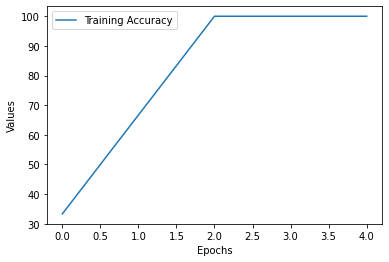

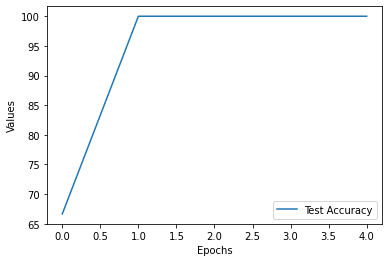

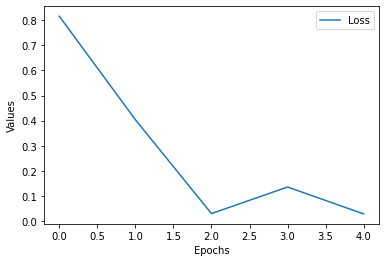

In [237]:
#|export
# Plot the loss and accuracy
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.show()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.show()
plt.plot(loss_list, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.show()

In [238]:
import nbdev
nbdev.export.nb_export('crack.ipynb','crack.py')